In [1]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU

leyendo imagenes de  C:\Users\Hp\OneDrive\Documentos\Proyecto\Git\Proyecto\CarneDataset\train\
C:\Users\Hp\OneDrive\Documentos\Proyecto\Git\Proyecto\CarneDataset\train\CLASS_02 1
C:\Users\Hp\OneDrive\Documentos\Proyecto\Git\Proyecto\CarneDataset\train\CLASS_03 62
C:\Users\Hp\OneDrive\Documentos\Proyecto\Git\Proyecto\CarneDataset\train\CLASS_04 213
C:\Users\Hp\OneDrive\Documentos\Proyecto\Git\Proyecto\CarneDataset\train\CLASS_05 105
C:\Users\Hp\OneDrive\Documentos\Proyecto\Git\Proyecto\CarneDataset\train\CLASS_06 949
C:\Users\Hp\OneDrive\Documentos\Proyecto\Git\Proyecto\CarneDataset\train\CLASS_07 37
C:\Users\Hp\OneDrive\Documentos\Proyecto\Git\Proyecto\CarneDataset\train\CLASS_08 204
Directorios leidos: 7
Imagenes en cada directorio [63, 213, 105, 949, 37, 204, 62]
Suma Total de imagenes en subdirectorios: 1633


(-0.5, 383.5, 215.5, -0.5)

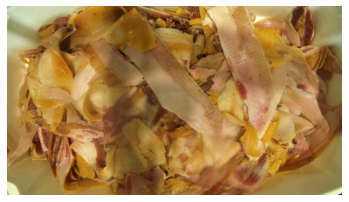

In [2]:
# Llamar a dirección de las imágenes de entrenamiento "train"
dirname = os.path.join(os.getcwd(), 'CarneDataset\\train')
imgpath = dirname + os.sep
 
images = []
directories = []
dircount = []
prevRoot=''
cant=0
 
print("leyendo imagenes de ",imgpath)
 
for root, dirnames, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            cant=cant+1
            filepath = os.path.join(root, filename)
            image = plt.imread(filepath)
            images.append(image)
            b = "Leyendo..." + str(cant)
            print (b, end="\r")
            if prevRoot !=root:
                print(root, cant)
                prevRoot=root
                directories.append(root)
                dircount.append(cant)
                cant=0
dircount.append(cant)
 
dircount = dircount[1:]
dircount[0]=dircount[0]+1
print('Directorios leidos:',len(directories))
print("Imagenes en cada directorio", dircount)
print('Suma Total de imagenes en subdirectorios:',sum(dircount))

fig, ax = plt.subplots()
ax.imshow(images[544]) #images es el array completo con todas las imagenes y imshow muestra el gráfico

ax.axis('off') #Quita la escala de las gráficas eje x y 
  
#plt.show()




In [3]:
labels=[]
indice=0

# Contador de las clases que existen para generar un array de índices
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)
    indice=indice+1
print("Cantidad etiquetas creadas: ",len(labels))
 
tcarnes=[]
indice=0

for directorio in directories:
    name = directorio.split(os.sep) #Función para limpiar la ruta en un array de palabras
    print(indice , name[len(name)-1]) #Mostrar el último elemento del array
    tcarnes.append(name[len(name)-1]) #Asignar el ultimo elemento del array name al array de las clases
    indice=indice+1
    
 
y = np.array(labels) # función labels tiene las clases
X = np.array(images, dtype=np.uint8) #convierto de lista a numpy, con formato entero, sin signo y de 8 bits


 
# Buscar el numero único desde las etiquetas de entrenamiento "train"
classes = np.unique(y) #limpia los indices de las clases que estan repetidos para dejarlos con una sola visualización
nClasses = len(classes) #impresión del numero total de indices
print('Total número de salidas : ', nClasses)
print('Salidas de indices asociados a las clases: ', classes)
# Visualización del array indices vs clase
print('Salida de array tcarnes:', tcarnes)

print('Salida y:', y[1632])
print('Salida label:', labels[1632]) #la ultima imagen relacionada al indice asociado a las clases

print('Salida X:', X[1])
print('Salida imagenes:', images[1]) #la ultima imagen relacionada al indice asociado a las clases


Cantidad etiquetas creadas:  1633
0 CLASS_02
1 CLASS_03
2 CLASS_04
3 CLASS_05
4 CLASS_06
5 CLASS_07
6 CLASS_08
Total número de salidas :  7
Salidas de indices asociados a las clases:  [0 1 2 3 4 5 6]
Salida de array tcarnes: ['CLASS_02', 'CLASS_03', 'CLASS_04', 'CLASS_05', 'CLASS_06', 'CLASS_07', 'CLASS_08']
Salida y: 6
Salida label: 6
Salida X: [[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
Salida imagenes: [[[0.8156863  0.8352941  0.6       ]
  [0.8156863  0.827451   0.6       ]
  [0.8039216  0.8156863  0.5882353 ]
  ...
  [0.03921569 0.05098039 0.01176471]
  [0.03921569 0.04705882 0.01176471]
  [0.03921569 0.05490196 0.011

In [4]:
#Mezclar todo y crear los grupos de entrenamiento y testing
train_X,test_X,train_Y,test_Y = train_test_split(X,y,test_size=0.2)
train_X = X
train_Y = y
print('Forma de Entrenamiento de datos : ', train_X.shape, train_Y.shape)
print('Forma de evaluacion de datos: ', test_X.shape, test_Y.shape)
 
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.
 
# Cambie las etiquetas de la codificación categórica a one-hot encoding

train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)
 
# Muestra del cambio de la etiqueta de la categoría usando one-hot encoding
print('Etiqueta Original:', train_Y[0])
print('Despues de la Conversión a one-hot:', train_Y_one_hot[0])
 
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)
 
print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

Forma de Entrenamiento de datos :  (1633, 216, 384, 3) (1633,)
Forma de evaluacion de datos:  (327, 216, 384, 3) (327,)
Etiqueta Original: 0
Despues de la Conversión a one-hot: [1. 0. 0. 0. 0. 0. 0.]
(1306, 216, 384, 3) (327, 216, 384, 3) (1306, 7) (327, 7)


In [5]:
INIT_LR = 1e-3
epochs = 6
batch_size = 64

meat_model = Sequential()
meat_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(216,384,3)))
meat_model.add(LeakyReLU(alpha=0.1))
meat_model.add(MaxPooling2D((2, 2),padding='same'))
meat_model.add(Dropout(0.5))

meat_model.add(Flatten())
meat_model.add(Dense(32, activation='linear'))
meat_model.add(LeakyReLU(alpha=0.1))
meat_model.add(Dropout(0.5)) 
meat_model.add(Dense(nClasses, activation='softmax'))

meat_model.summary()

meat_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adagrad(lr=INIT_LR, decay=INIT_LR / 100),metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 216, 384, 32)      896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 216, 384, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 108, 192, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 108, 192, 32)      0         
                                                                 
 flatten (Flatten)           (None, 663552)            0         
                                                                 
 dense (Dense)               (None, 32)                21233696  
                                                        

C:\Users\Hp\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adagrad.py:77: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adagrad, self).__init__(name, **kwargs)


In [6]:
meat_train_dropout = meat_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))
 
# guardamos la red, para reutilizarla en el futuro, sin tener que volver a entrenar
meat_model.save("meat_mnist.h5py")

Epoch 1/6
21/21 [==============================] - 91s 4s/step - loss: 1.9272 - accuracy: 0.5421 - val_loss: 1.8655 - val_accuracy: 0.5963
Epoch 2/6
21/21 [==============================] - 81s 4s/step - loss: 1.7360 - accuracy: 0.5773 - val_loss: 1.5258 - val_accuracy: 0.5963
Epoch 3/6
21/21 [==============================] - 77s 4s/step - loss: 1.5240 - accuracy: 0.5735 - val_loss: 1.4141 - val_accuracy: 0.5963
Epoch 4/6
21/21 [==============================] - 88s 4s/step - loss: 1.5106 - accuracy: 0.5743 - val_loss: 1.4041 - val_accuracy: 0.5963
Epoch 5/6
21/21 [==============================] - 75s 4s/step - loss: 1.5070 - accuracy: 0.5758 - val_loss: 1.3868 - val_accuracy: 0.5963
Epoch 6/6
21/21 [==============================] - 76s 4s/step - loss: 1.5033 - accuracy: 0.5697 - val_loss: 1.3895 - val_accuracy: 0.5963


INFO:tensorflow:Assets written to: meat_mnist.h5py\assets


INFO:tensorflow:Assets written to: meat_mnist.h5py\assets


In [7]:
test_eval = meat_model.evaluate(test_X, test_Y_one_hot, verbose=1)
 
print('Pruebas perdidas:', test_eval[0])
print('Precisión de la Prueba:', test_eval[1])

11/11 [==============================] - 6s 558ms/step - loss: 1.3809 - accuracy: 0.5963
Pruebas perdidas: 1.380889654159546
Precisión de la Prueba: 0.5963302850723267


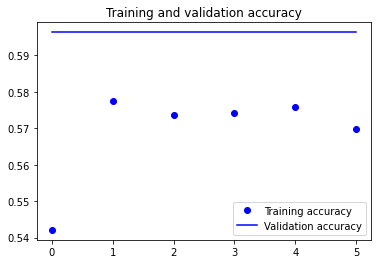

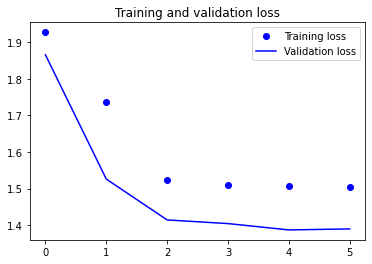

In [9]:
# Evaluamos la Red
accuracy = meat_train_dropout.history['accuracy']
val_accuracy = meat_train_dropout.history['val_accuracy']
loss = meat_train_dropout.history['loss']
val_loss = meat_train_dropout.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [10]:
predicted_classes2 = meat_model.predict(test_X)

11/11 [==============================] - 5s 461ms/step


In [11]:
predicted_classes=[]
for predicted_meat in predicted_classes2:
    predicted_classes.append(predicted_meat.tolist().index(max(predicted_meat)))
predicted_classes=np.array(predicted_classes)

In [12]:
predicted_classes.shape, test_Y.shape

((327,), (327,))

Found 195 correct labels


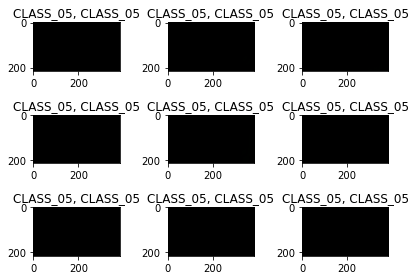

In [13]:
#Aprendamos de los errores
correct = np.where(predicted_classes==test_Y)[0]
print("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct].reshape(216,384,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(tcarnes[predicted_classes[correct]],
                                                    tcarnes[test_Y[correct]]))

    plt.tight_layout()

Found 132 incorrect labels


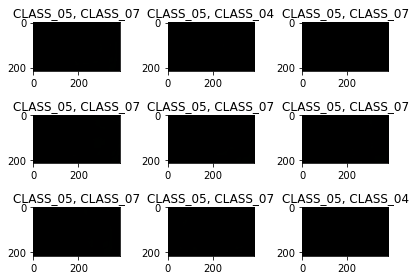

In [14]:
incorrect = np.where(predicted_classes!=test_Y)[0]
print("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect].reshape(216,384,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(tcarnes[predicted_classes[incorrect]],
                                                    tcarnes[test_Y[incorrect]]))
    plt.tight_layout()

In [15]:
target_names = ["Class {}".format(i) for i in range(nClasses)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00        10
     Class 1       0.00      0.00      0.00        35
     Class 2       0.00      0.00      0.00        22
     Class 3       0.60      1.00      0.75       195
     Class 4       0.00      0.00      0.00         4
     Class 5       0.00      0.00      0.00        46
     Class 6       0.00      0.00      0.00        15

    accuracy                           0.60       327
   macro avg       0.09      0.14      0.11       327
weighted avg       0.36      0.60      0.45       327



C:\Users\Hp\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


- Dimensiones de la imagen:
(216, 384, 3)


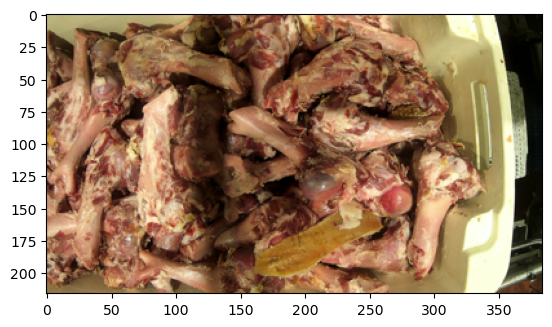

In [1]:
# cargar la imagen que vamos a utilizar para realizar los cambios de color, detección de bordes y eliminación de ruido
import matplotlib.pyplot as plt
from skimage import io
image=io.imread("CarneDataset\\train\\CLASS_02\\05-CAPTURE_20220421_053226_860.png")/255.0 # imread lee las imagenes con los pixeles codificados como enteros 
# en el rango 0-255. Por eso la convertimos a flotante y en el rango 0-1

print("- Dimensiones de la imagen:")
print(image.shape)
plt.imshow(image,vmin=0,vmax=1)

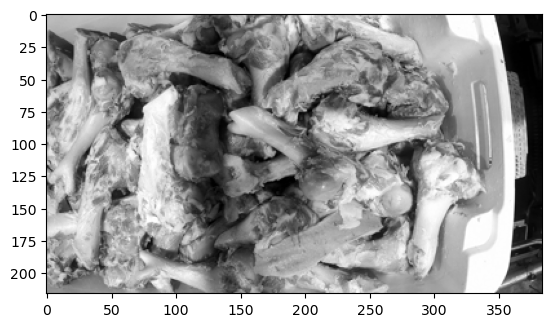

In [2]:
#Imagen color Gris
import numpy as np 
pic_ar=np.asarray(image)
pic_ar.shape

plt.imshow(pic_ar[:,:,0],cmap="gray")

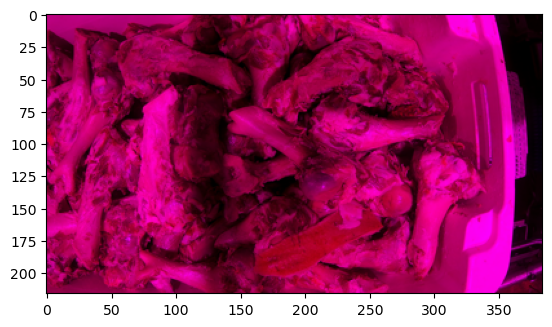

In [3]:
#Imagen color rojo
pic_ar=np.asarray(image)
pic_ar[:,:,1]=0
plt.imshow(pic_ar)